# Example 1: Basic Simulation and Recovery of SCD with NPTFit

In this example we cover how to run a point source Monte Carlo simulation for a user defined template and source-count distribution (SCD) with NPTFit-Sim. In this example we use a uniform template to produce a simulated counts map. The counts map is then run through NPTFit to recover the injected SCD.

The relevant modules are imported.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../NPTFit-Sim/')
import ps_mc
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

## Define Source Count Distribution & Load Templates

Begin by defining the source count distribution. Here we use a SCD with one break.

It is important to remember that input parameters of the SCD are defined from high to low flux (or counts). This means, for example, in a model with a single broken power law the index that corresponds to higher flux should be listed as the first value in your array.

In [2]:
n = np.array([15.00,-1.0]) # indexes for SCD
S = np.array([10.00]) # SCD break, here in terms of counts
A = -1.00 # log-normilization
name = "simulation" # Name of output file

Create a basic template and exposure map.

Here we use a low nside for uniform exposure and template maps.

In [3]:
nside = 16
npix = hp.nside2npix(nside)

temp = 0.1 * np.ones(npix).astype(float)
EXP = np.ones(npix).astype(float)

The SCD as described above is in terms of counts. NPTFit-Sim uses source count distributions that are defined in terms of flux, i.e. dN/dF as opposed to dN/dS. The two distributions are related by the exposure as follows:

$$\frac{dN_{p}}{dS}(S;\theta) = \frac{1}{E_{p}} \frac{dN_{p}}{dF}(F = S/E_{p};\theta)$$

To correct for this effect, the mean exposure is calculated from the exposure map and divided through the count break, $S$, to form a flux break. Additionally, the normilization, $A$, is multiplied by the mean exposure to transform the SCD in terms of counts to flux. Note, we can just add the logarithm of the mean exposure to the log-normalization.

In [4]:
# Calculate the mean exposure
mean_exp = np.mean(EXP)
                   
# Calculate flux break from counts break and mean exposure
F = S / mean_exp
                   
# Cornvert log-normilization term, A, into terms of flux
A = A + np.log10(mean_exp)

## User Defined PSF

Prior to running the simulation, the user must define a PSF using a lambda function. For this simple case we will only consider a Gaussian.

Your PSF must be a defined in terms of radians.

In [5]:
# Define parameters that specify the PSF
sigma = 2.00 * np.pi/180.

# Lambda function to pass user defined PSF
psf_r = lambda r: np.exp(-r**2. / (2.*sigma**2.))

## Run NPTFit-Sim

The simulation can be started by calling on the run function from the ps_mc module that was imported earlier. It depends on the parameters of the SCD, the exposure and template maps, and the PSF. It also gives the user the option to save their map to a .npy file with the name of their choice. Simulations with ~ 1000 sources will take no more than a few seconds to run.

The [0] at the end extracts the single map, as we have created this assuming a single energy bin.

Number of sources from Poisson draw: 165
Sampling the source count distribution.
Simulating counts map ...
Done simulation.


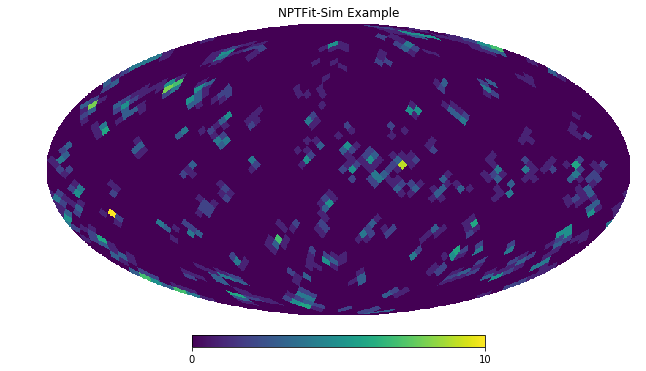

In [6]:
sim_map = ps_mc.run(n,F,A,temp,EXP,psf_r,name="map",save=False)[0]

#View the output on a HEALPix map
hp.mollview(sim_map,title="NPTFit-Sim Example")

With our simulation complete, we want to see if we can recover the injected source count distribution. To do this, we will use NPTFit.
# Recover SCD with NPTFit
To recover the injected source count distribution, we will run NPTFit using the templates from making the map. First, load in the relevant modules.

In [7]:
from NPTFit import nptfit
from NPTFit import create_mask as cm
from NPTFit import dnds_analysis
from NPTFit import psf_correction as pc

## Set Up Scan
Begin with NPTFit as you normally would.

In [8]:
n = nptfit.NPTF(tag='Example')
n.load_data(sim_map,EXP)

Add a non-poisson model for the template you created earlier, remembering to rescale the template.

In [9]:
n.add_template(temp, 'examp_np', units='PS')

#Add the Non-poisson model
n.add_non_poiss_model('examp_np',
                      ['$A_\mathrm{examp}^\mathrm{ps}$','$n_1^\mathrm{examp}$','$n_2^\mathrm{examp}$','$S_b^{(1), \mathrm{examp}}$'],
                      [[-6.,1.],[2.05,30],[-2.0,1.95],[0.05,40.0]],
                      [True,False,False,False])

Calculate the relevant PSF correction for your PSF. If you are using a Gaussian, as we do in this example, recall that you can enter the Gaussian standard deviation into PSFCorrection directly. 

In [10]:
pc_inst = pc.PSFCorrection(psf_sigma_deg = 2.0,nside = nside)

f_ary = pc_inst.f_ary
df_rho_div_f_ary = pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

File saved as: /zfs/nrodd/NPTFit-Sim/examples/psf_dir/gauss_16_2.0_10_50000_1000_0.01.npy
No mask set; defaulting to a blank mask
The number of parameters to be fit is 4


Setup for the scan is complete, now we can simply run it.

In [11]:
n.perform_scan(nlive=500)

When the scan is finnished, we can now make a triangle plot and reproduce the injected source-count distribution.

  analysing data from /zfs/nrodd/NPTFit-Sim/examples/chains/Example/.txt


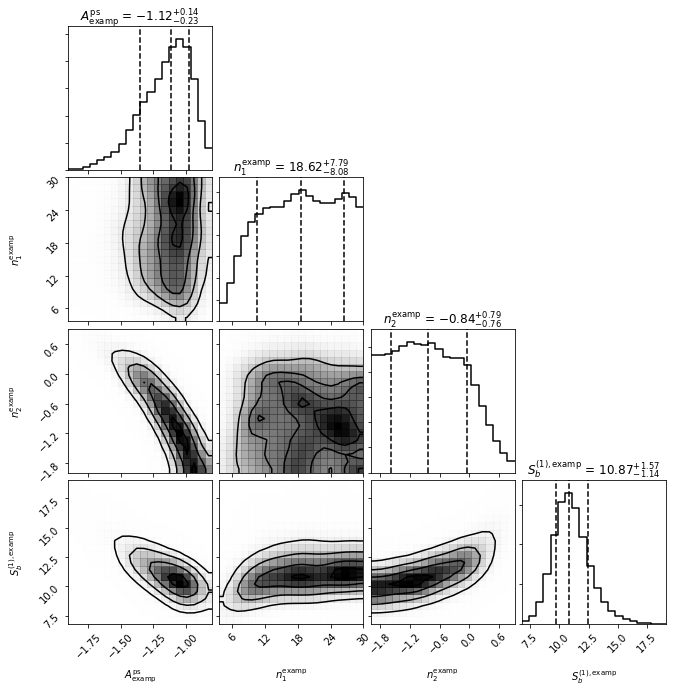

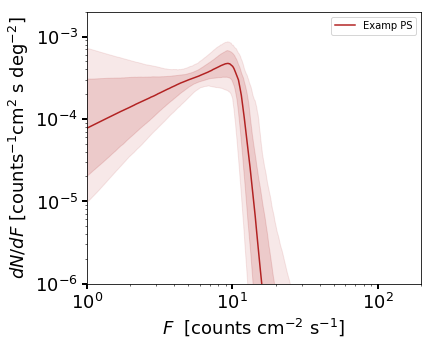

In [12]:
n.load_scan()

an = dnds_analysis.Analysis(n)

an.make_triangle()

plt.figure(figsize=[6,5])

plt.xlim([1e0,2e2])
plt.ylim([1e-6,2e-3])

an.plot_source_count_median('examp_np',smin=0.01,smax=1000,nsteps=1000,color='firebrick',spow=0,label='Examp PS')
an.plot_source_count_band('examp_np',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='firebrick',alpha=0.15,spow=0)
an.plot_source_count_band('examp_np',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='firebrick',alpha=0.1,spow=0)

plt.yscale('log')
plt.xscale('log')

plt.tick_params(axis='x', length=5, width=2, labelsize=18)
plt.tick_params(axis='y', length=5, width=2, labelsize=18)
plt.ylabel('$dN/dF$ [counts$^{-1}$cm$^2$ s deg$^{-2}$]', fontsize=18)
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]', fontsize=18)
plt.legend(fancybox=True)